## Transfer Learning on Cats-Dogs Classification - Feature Extraction

#### Features are extracted from a MobileNet-V2 model pre-trained on ImageNet data, then passed through a new classification head to classify cats vs. dogs.
Adapted from https://www.tensorflow.org/tutorials/images/transfer_learning

### HPC and Data Science Summer Institute
Mai H. Nguyen, UC San Diego

-----

In [1]:
import tensorflow as tf
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras import applications
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import datetime

2023-08-07 19:09:03.716985: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print("Tensorflow version:",tf.__version__)
!python --version

Tensorflow version: 2.9.1
Python 3.8.10


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!nvidia-smi

Mon Aug  7 19:09:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   43C    P0    54W / 300W |      3MiB / 32768MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Set logging level
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
# Set random generator seed
seed = 1234

# Set Python seed, NumPy seed, and TensorFlow seed
tf.keras.utils.set_random_seed(seed)

# Set numpy random generator
# np.random.seed(seed)

# Set python built-in random generator
# random.seed(seed)

# Set tf global random seed
# tf.random.set_seed(seed)

# Disable hash randomization by specifying the value 0.
# os.environ['PYTHONHASHSEED'] = '0'

# Potential randomness from CUDNN
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC']= '1'

### Set image location and dimensions

In [7]:
import os 

from os.path import expanduser
HOME = expanduser("~")
data_path = HOME + '/data/catsVsDogs'
print (data_path)

# Location of images
train_data_dir = data_path + '/train'
val_data_dir   = data_path + '/val'
test_data_dir  = data_path + '/test'

print ('Train path:' + train_data_dir)
print ('Validation path:' + val_data_dir)
print ('Test path:' + test_data_dir)

/home/train107/data/catsVsDogs
Train path:/home/train107/data/catsVsDogs/train
Validation path:/home/train107/data/catsVsDogs/val
Test path:/home/train107/data/catsVsDogs/test


In [8]:
# Image dimensions
img_width, img_height = 224,224 
IMG_SIZE = (img_width,img_height)
IMG_SHAPE = IMG_SIZE + (3,)

### Prepare data

In [9]:
# Batch size
BATCH_SIZE = 16

# Data augmentation setup
#rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
rescale = tf.keras.applications.mobilenet_v2.preprocess_input
train_datagen      = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, preprocessing_function = rescale)
validation_datagen = ImageDataGenerator(preprocessing_function = rescale)
test_datagen       = ImageDataGenerator(preprocessing_function = rescale)

# Set up generator to read images found in subfolders of training data directory,
# and indefinitely generate batches of image data (scaled).  This is for training data.
train_generator = train_datagen.flow_from_directory(train_data_dir,target_size=IMG_SIZE,
                                              batch_size = BATCH_SIZE, class_mode='binary', 
                                              shuffle = True, seed = seed)           

# Set up generator to generate batched of validation data for model
validation_generator = validation_datagen.flow_from_directory(val_data_dir,target_size=IMG_SIZE,
                                                   batch_size = BATCH_SIZE,class_mode='binary',
                                                   shuffle = False, seed = seed)
# Set up generator to generate batched of test data for model
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=IMG_SIZE,
                                             batch_size = BATCH_SIZE, class_mode='binary',
                                             shuffle = False, seed = seed)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


### Load pre-trained model

In [10]:
#Load pre-trained model's Imagenet weights not including the fully connected layers
base_model = applications.MobileNetV2(include_top = False, weights = 'imagenet', input_shape=IMG_SHAPE)

# Freeze all weights of pre-trained model
base_model.trainable = False

# Needed to keep BatchNormalization layers in inference mode for pre-trained model. 
# See https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization 
base_model.training  = False

print ('Base model loaded')

# Uncomment to look at pre-trained model's architecture
# base_model.summary()

2023-08-07 19:09:06.879905: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 19:09:07.343391: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2023-08-07 19:09:07.343509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0


Base model loaded


### Create top model

In [11]:
img_inputs = tf.keras.Input(shape=(img_width, img_height, 3))
base_outputs = base_model(img_inputs)

GlobalAveragePooler2D = GlobalAveragePooling2D()
GlobalAveragePooler2D_outputs = GlobalAveragePooler2D(base_outputs)

Dropper = Dropout(0.2)
DroppedOut_outputs = Dropper(GlobalAveragePooler2D_outputs)

DenseLayer = Dense(1, activation='sigmoid')
outputs = DenseLayer(DroppedOut_outputs)

model = tf.keras.Model(inputs=img_inputs, outputs=outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable

### Train top model

In [13]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss= losses.BinaryCrossentropy(),metrics=['accuracy'])

In [14]:
%%time

# Train top model for 5 epochs
EPOCHS = 5

train_history = model.fit(train_generator,validation_data=validation_generator, epochs=EPOCHS)

Epoch 1/5


2023-08-07 19:09:11.217979: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500


125/125 [==============================] - 21s 147ms/step - loss: 0.5627 - accuracy: 0.7160 - val_loss: 0.3767 - val_accuracy: 0.8900
Epoch 2/5
125/125 [==============================] - 18s 142ms/step - loss: 0.3281 - accuracy: 0.9060 - val_loss: 0.2353 - val_accuracy: 0.9425
Epoch 3/5
125/125 [==============================] - 18s 142ms/step - loss: 0.2273 - accuracy: 0.9425 - val_loss: 0.1713 - val_accuracy: 0.9625
Epoch 4/5
125/125 [==============================] - 18s 142ms/step - loss: 0.1778 - accuracy: 0.9485 - val_loss: 0.1376 - val_accuracy: 0.9750
Epoch 5/5
125/125 [==============================] - 17s 140ms/step - loss: 0.1444 - accuracy: 0.9655 - val_loss: 0.1168 - val_accuracy: 0.9775
CPU times: user 1min 30s, sys: 1.27 s, total: 1min 31s
Wall time: 1min 32s


In [15]:
# Save weights from trained model
model.save("models/features_model")

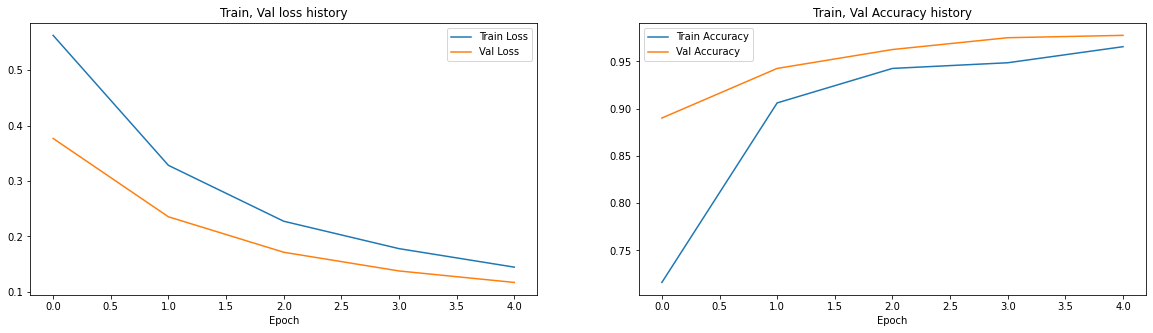

In [16]:
# Plot train and validation history
fig, axs = plt.subplots(1,2, figsize= (20,5))
axs[0].plot(train_history.history['loss'])
axs[0].plot(train_history.history['val_loss'])
axs[0].set_title("Train, Val loss history")
axs[0].set_xlabel("Epoch")
axs[0].legend(["Train Loss","Val Loss"])

axs[1].plot(train_history.history['accuracy'])
axs[1].plot(train_history.history['val_accuracy'])
axs[1].set_title("Train, Val Accuracy history")
axs[1].set_xlabel("Epoch")
axs[1].legend(["Train Accuracy","Val Accuracy"])

### Evaluation and Inference

In [17]:
# Get train data accuracy
_, train_accuracy = model.evaluate(train_generator)
print("Train data accuracy:", train_accuracy)

# Get test data accuracy
_, test_accuracy = model.evaluate(test_generator)
print("Test data accuracy:", test_accuracy)

125/125 [==============================] - 17s 134ms/step - loss: 0.1268 - accuracy: 0.9705
Train data accuracy: 0.9704999923706055
25/25 [==============================] - 1s 32ms/step - loss: 0.1244 - accuracy: 0.9775
Test data accuracy: 0.9775000214576721


In [18]:
# Get predicted value and the ground truth value of test data
pred = (model.predict(test_generator) > 0.5).astype("int32")
true = test_generator.classes

25/25 [==============================] - 1s 30ms/step


In [19]:
# Get evaluation metrics for test data
print(classification_report(y_true= true, y_pred = pred, target_names=['cats', 'dogs'], digits=4))

              precision    recall  f1-score   support

        cats     0.9799    0.9750    0.9774       200
        dogs     0.9751    0.9800    0.9776       200

    accuracy                         0.9775       400
   macro avg     0.9775    0.9775    0.9775       400
weighted avg     0.9775    0.9775    0.9775       400



### Perform inference on test images

In [20]:
def image_loader(img_file):
    img = load_img(img_file, target_size = (img_width, img_height))
    imgplot = plt.imshow(img)
    plt.show()
    # img = img_to_array(img) / 255
    img = (img_to_array(img)/127.5)-1.0
    img = np.expand_dims(img, axis = 0) #model input is (1,width,height,channels)
    return img

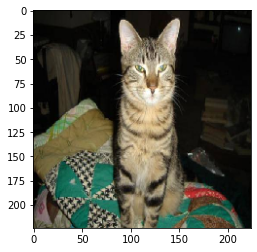

1/1 [==============================] - 1s 625ms/step
[[0.13514]]


In [21]:
test_image = data_path + '/test/cats/cat.1070.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

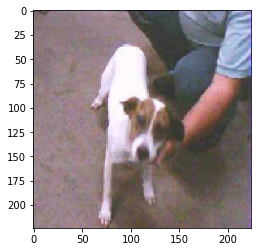

1/1 [==============================] - 0s 23ms/step
[[0.96]]


In [22]:
test_image = data_path + '/test/dogs/dog.1233.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

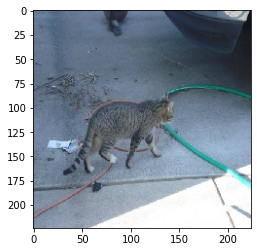

1/1 [==============================] - 0s 23ms/step
[[0.60455]]


In [23]:
test_image = data_path + '/test/cats/cat.1080.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

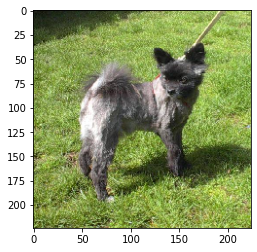

1/1 [==============================] - 0s 24ms/step
[[0.43811]]


In [24]:
test_image = data_path + '/test/dogs/dog.1132.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))

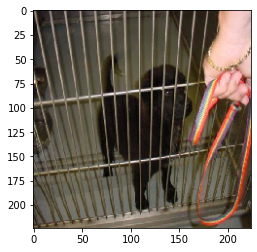

1/1 [==============================] - 0s 23ms/step
[[0.62855]]


In [25]:
test_image = data_path + '/test/dogs/dog.1311.jpg'
img = image_loader(test_image)
img_y_pred = model.predict(img) 
print(np.round(img_y_pred,5))